<a href="https://colab.research.google.com/github/mattcho1157/f1_race_prediction_model/blob/main/dataset_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **F1 Race Prediction Model | Dataset Creation**
The first step of building the F1 prediction model was to retrieve relevant features and data for training and testing. After comparing multiple online F1 datasets, I found that [Ergast API](http://ergast.com/mrd/) provides the most comprensive historical record of F1 data since the beginning of the World Championships in 1950. Once the data tables were downloaded as CSV files, they were preprocessed to generate a single data table containing potential input and output features.


## **1. Google Colab project environment**
Working in Google Colab, it was most convenient to store all necessary project files in a Google Drive folder. Hence, to access the files, you must first mount your Google Drive content on your Colab working environment:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

CSV file paths in my Google Drive folder:

In [ ]:
races_path = '/content/drive/My Drive/f1_prediction/data/races.csv'
driver_standings_path = '/content/drive/My Drive/f1_prediction/data/driver_standings.csv'
const_standings_path = '/content/drive/My Drive/f1_prediction/data/constructor_standings.csv'
quali_results_path = '/content/drive/My Drive/f1_prediction/data/qualifying.csv'
race_results_path = '/content/drive/My Drive/f1_prediction/data/results.csv'
final_dataset_path = '/content/drive/My Drive/f1_prediction/data.csv'

## **2. Importing necessary packages**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **3. Feature labels**
15 viable features were engineered after thorough analysis of the F1 dataset. Note that three of these features are merely missing value indicators, while `race_id` and `driver_id` were included for reference only (i.e. they are not actual features). This gave a total of 17 columns for the final dataset table. When actually building the prediction model, some of the listed features were discarded or used to generate more sophisticated features to increase the model's performance. Nonetheless, most of the features were directly implemented as input or output features.

Some feature labels contain one of the three prefixes below:
* cs - current season
* csa - current season average
* p3sa - previous 3 seasons average

In [ ]:
column_labels = [
	# reference features
	'race_id',
	'driver_id',

	# driver features
	'start_pos',
	'gap_to_pole',

	'cs_driver_results_missing',
	'cs_driver_standing',
	'cs_driver_podium_rate',
	'csa_pos_change',
	'csa_finish_pos',

	'p3s_driver_results_missing',
	'p3sa_pos_change_same_circuit',
	'p3sa_finish_pos_same_circuit',

	# constructor features
	'cs_const_results_missing',
	'cs_const_standing',
	'cs_const_podium_rate',

	# circuit feature
	'circuit_avg_pos_change',

	# race result
	'finish_pos'
]

## **4. Preprocessing data from CSV files**
Before generating data for the features mentioned above, you have to clean up the data (e.g. discarding irrelevant columns, imputing missing values, creating new columns, merging dataframes). Reading the CSV files stored in my Google Drive:

In [ ]:
races = pd.read_csv(races_path)[['race_id', 'year', 'round', 'circuit_id']]
driver_standings = pd.read_csv(driver_standings_path)[['race_id', 'driver_id', 'position']]
const_standings = pd.read_csv(const_standings_path)[['race_id', 'constructor_id', 'position']]
quali_results = pd.read_csv(quali_results_path)[['race_id', 'driver_id', 'q1', 'q2', 'q3']]
race_results = pd.read_csv(race_results_path)[['race_id', 'driver_id', 'constructor_id', 'grid', 'position']]

In each of the dataframes, '\N' string values were replaced with `np.NaN` numpy objects to indicate empty cells.

In [ ]:
races = races.replace('\\N', np.NaN)
driver_standings = driver_standings.replace('\\N', np.NaN)
const_standings = const_standings.replace('\\N', np.NaN)
quali_results = quali_results.replace('\\N', np.NaN)
race_results = race_results.replace('\\N', np.NaN)

Additional changes were made to the `quali_results` dataframe. Rows without a q1 time were removed as it indicates that the driver did not partake in qualifying for that race. As well, the datatype of the qualifying times were converted from `str` to `datetime.time` for allowing time calculations down the road. Two new columns called `quali_fastest_lap` and `quali_slowest_lap` were added for calculating the driver's normalised deviation from pole position time (i.e. gap to pole).

In [ ]:
# removing rows without a q1 time
quali_results = quali_results[pd.notna(quali_results['q1'])]
# converting quali time datatype from str to datetime.time
quali_results['q1'] = pd.to_datetime(quali_results['q1'], format= '%M:%S.%f', errors='coerce')
quali_results['q2'] = pd.to_datetime(quali_results['q2'], format= '%M:%S.%f', errors='coerce')
quali_results['q3'] = pd.to_datetime(quali_results['q3'], format= '%M:%S.%f', errors='coerce')
# new columns - fastest and slowest quali lap times for each driver in each race
quali_results['fastest_lap'] = quali_results[['q1', 'q2', 'q3']].min(axis=1)
quali_results['slowest_lap'] = quali_results[['q1', 'q2', 'q3']].max(axis=1)

Additional changes were also made to the `race_results` dataframe. Columns were renamed to match the engineered feature labels, while rows where the driver had a DNF were removed to reduce noisy data. Similarly, to remove rows where the driver did not partake in qualifying, `race_results` was merged with the multi-index columns of `quali_results`.

In [ ]:
# renaming column names to match the feature labels
race_results = race_results.rename(columns={'grid': 'start_pos', 'position': 'finish_pos'})
# removing rows where the driver had a DNF
race_results = race_results[pd.notna(race_results['finish_pos'])]
race_results['finish_pos'] = race_results['finish_pos'].astype(int)
# removing rows where the driver did not partake in qualifying via a merge 
race_results = race_results.merge(quali_results[['race_id', 'driver_id']], on=['race_id', 'driver_id'], how='inner')

Below are the first 5 rows of each of the four preprocessed dataframes that will be used to extract the necessary data corresponding to the engineered features:

In [ ]:
races.head()

,race_id,year,round,circuit_id
0,1,2009,1,1
1,2,2009,2,2
2,3,2009,3,17
3,4,2009,4,3
4,5,2009,5,4


In [ ]:
driver_standings.head()

,race_id,driver_id,position
0,18,1,1
1,18,2,2
2,18,3,3
3,18,4,4
4,18,5,5


In [ ]:
const_standings.head()

,race_id,constructor_id,position
0,18,1,1
1,18,2,3
2,18,3,2
3,18,4,4
4,18,5,5


In [ ]:
quali_results.head()

,race_id,driver_id,q1,q2,q3,fastest_lap,slowest_lap
0,18,1,1900-01-01 00:01:26.572,1900-01-01 00:01:25.187,1900-01-01 00:01:26.714,1900-01-01 00:01:25.187,1900-01-01 00:01:26.714
1,18,9,1900-01-01 00:01:26.103,1900-01-01 00:01:25.315,1900-01-01 00:01:26.869,1900-01-01 00:01:25.315,1900-01-01 00:01:26.869
2,18,5,1900-01-01 00:01:25.664,1900-01-01 00:01:25.452,1900-01-01 00:01:27.079,1900-01-01 00:01:25.452,1900-01-01 00:01:27.079
3,18,13,1900-01-01 00:01:25.994,1900-01-01 00:01:25.691,1900-01-01 00:01:27.178,1900-01-01 00:01:25.691,1900-01-01 00:01:27.178
4,18,2,1900-01-01 00:01:25.960,1900-01-01 00:01:25.518,1900-01-01 00:01:27.236,1900-01-01 00:01:25.518,1900-01-01 00:01:27.236


Notice how converting the the qualifying times from `str` to `datetime64` attaches the default date '1900-01-01' in front of the time. The date section is kept merely to utilise certain datetime functionalities like datetime subtraction and thus, can be ignored. 

In [ ]:
race_results.head()

,race_id,driver_id,constructor_id,start_pos,finish_pos
0,18,1,1,1,1
1,18,2,2,5,2
2,18,3,3,7,3
3,18,4,4,11,4
4,18,5,1,3,5


## **5. Retrieving data pertaining to the engineered features**
Specific data corresponding with the features listed above were extracted from the preprocessed dataframes and appended to the `final_dataset` list. This was achieved via a for-loop iterating through the rows of the `results` dataframe.

In [ ]:
# store the final dataset
final_dataset = []

for row in race_results.itertuples(index=False, name='Row'):

	driver_id = getattr(row, 'driver_id')
	const_id = getattr(row, 'constructor_id')
	race_id = getattr(row, 'race_id')
	race_year = races[races['race_id'] == race_id]['year'].iloc[0]
	race_round = races[races['race_id'] == race_id]['round'].iloc[0]
	race_circuit = races[races['race_id'] == race_id]['circuit_id'].iloc[0]
	# if this is not the first race of the season, get the race_id of the previous race
	if race_round != 1:
		prev_race_id = races[(races['year'] == race_year) & (races['round'] == race_round - 1)]['race_id'].iloc[0]

	##################
	# QUALI FEATURES #
	##################

	### STARTING GRID POSITION ###
	start_pos = getattr(row, 'start_pos')

	### GAP TO POLE ###
	# driver's fastest quali lap
	fastest_lap_driver = quali_results[(quali_results['race_id'] == race_id) 
			& (quali_results['driver_id'] == driver_id)]['fastest_lap'].iloc[0]
	# fastest and slowest quali laps out of all drivers on the grid
	fastest_lap_grid = min(quali_results[quali_results['race_id'] == race_id]['fastest_lap'])
	slowest_lap_grid = max(quali_results[quali_results['race_id'] == race_id]['slowest_lap'])
	# normalised deviation from pole lap time = deviation / range
	gap_to_pole = (fastest_lap_driver - fastest_lap_grid) / (slowest_lap_grid - fastest_lap_grid)
	gap_to_pole = round(gap_to_pole, 3)

	##################################
	# CURRENT SEASON DRIVER FEATURES #
	##################################

	# driver's results from current season
	cs_race_ids = races[(races['year'] == race_year) & (races['round'] < race_round)]['race_id']
	cs_results = race_results[(race_results['driver_id'] == driver_id) & (race_results['race_id'].isin(cs_race_ids))]

	# if this is the driver's first race of the season
	if cs_results.empty:
		cs_driver_results_missing = 1
		cs_driver_standing = cs_driver_podium_rate = csa_pos_change = csa_finish_pos = 0
	else:
		cs_driver_results_missing = 0

		### CURRENT SEASON DRIVER STANDING ###
		cs_driver_standing = driver_standings[(driver_standings['race_id'] == prev_race_id)
				& (driver_standings['driver_id'] == driver_id)]['position'].iloc[0]

		### CURRENT SEASON DRIVER PODIUM RATE ###
		cs_driver_no_podiums = cs_results[cs_results['finish_pos'] <= 3].shape[0]
		cs_no_previous_races = cs_results.shape[0]
		cs_driver_podium_rate = cs_driver_no_podiums / cs_no_previous_races
		cs_driver_podium_rate = round(cs_driver_podium_rate, 2)

		### CURRENT SEASON AVERAGE POSITION CHANGE (i.e. START - FINISH) ###
		csa_pos_change = (cs_results['start_pos'] - cs_results['finish_pos']).mean()
		csa_pos_change = round(csa_pos_change, 2)

		### CURRENT SEASON AVERAGE FINISHING POSITION ###
		csa_finish_pos = cs_results['finish_pos'].mean()
		csa_finish_pos = round(csa_finish_pos, 2)

	######################################
	# PREVIOUS 3 SEASONS DRIVER FEATURES #
	######################################

	# driver's results from previous 3 seasons where the race was on the same circuit as the current race
	p3s_race_ids = races[(race_year - 3 <= races['year']) & (races['year'] < race_year)]['race_id']
	p3s_results = race_results[(race_results['driver_id'] == driver_id) & (race_results['race_id'].isin(p3s_race_ids))]
	race_ids_same_circuit = races[races['circuit_id'] == race_circuit]['race_id']
	p3s_results_same_circuit = p3s_results[p3s_results['race_id'].isin(race_ids_same_circuit)]

	# if this is the driver's first race on this circuit
	if p3s_results_same_circuit.empty:
		p3s_driver_results_missing = 1
		p3sa_pos_change_same_circuit = p3sa_finish_pos_same_circuit = 0
	else:
		p3s_driver_results_missing = 0

		### PREVIOUS 3 SEASONS AVERAGE POSITION CHANGE (i.e. START - FINISH) ###
		p3sa_pos_change_same_circuit = (p3s_results_same_circuit['start_pos'] - p3s_results_same_circuit['finish_pos']).mean()
		p3sa_pos_change_same_circuit = round(p3sa_pos_change_same_circuit, 2)

		### PREVIOUS 3 SEASONS AVERAGE FINISHING POSITION ###
		p3sa_finish_pos_same_circuit = p3s_results_same_circuit['finish_pos'].mean()
		p3sa_finish_pos_same_circuit = round(p3sa_finish_pos_same_circuit, 2)

	#######################################
	# CURRENT SEASON CONSTRUCTOR FEATURES #
	#######################################

	# constructor's results from current season (i.e. results of both drivers in the team)
	cs_const_results = race_results[(race_results['constructor_id'] == const_id) & (race_results['race_id'].isin(cs_race_ids))]

	# if this is the constructor's first race of the season
	if cs_const_results.empty:
		cs_const_results_missing = 1
		cs_const_standing = cs_const_podium_rate = 0
	else:
		cs_const_results_missing = 0

		### CURRENT SEASON CONSTRUCTOR STANDING ###
		cs_const_standing = const_standings[(const_standings['race_id'] == prev_race_id)
				& (const_standings['constructor_id'] == const_id)]['position'].iloc[0]

		### CURRENT SEASON CONSTRUCTOR PODIUM RATE ###
		cs_const_no_podiums = cs_const_results[cs_const_results['finish_pos'] <= 3].shape[0]
		cs_const_no_previous_races = cs_const_results.shape[0]
		cs_const_podium_rate = cs_const_no_podiums / cs_const_no_previous_races
		cs_const_podium_rate = round(cs_const_podium_rate, 2)

	###################
	# CIRCUIT FEATURE #
	###################

	### CIRCUIT'S AVERAGE POSITION CHANGE FOR DRIVER'S STARTING POSITION (i.e. START - FINISH) ###
	results_same_circuit_and_start_pos = race_results[(race_results['race_id'].isin(
		  races[races['circuit_id'] == race_circuit]['race_id'])) & (race_results['start_pos'] == start_pos)]
	circuit_avg_pos_change = (results_same_circuit_and_start_pos['start_pos'] - results_same_circuit_and_start_pos['finish_pos']).mean()
	circuit_avg_pos_change = round(circuit_avg_pos_change, 2)

	###############
	# RACE RESULT #
	###############

	finish_pos = getattr(row, 'finish_pos')

	############################################
	# APPENDING DATA INTO DATAFRAME DICTIONARY #
	############################################
	final_dataset.append([
		race_id,
		driver_id,
		start_pos,
	    gap_to_pole,
	    cs_driver_results_missing,
		cs_driver_standing,
		cs_driver_podium_rate,
		csa_pos_change,
		csa_finish_pos,
		p3s_driver_results_missing, 
		p3sa_pos_change_same_circuit,
		p3sa_finish_pos_same_circuit,
		cs_const_results_missing,
		cs_const_standing,
		cs_const_podium_rate,
		circuit_avg_pos_change,
		finish_pos
	])

## **6. Exporting the `final_dataset` as a CSV file**
The `final_dataset` list now contains all the data necessary to start training a prediction model. The list is transformed into a pandas dataframe, which is then uploaded to the designated Google Drive folder in CSV format.

In [ ]:
final_dataset = pd.DataFrame(final_dataset, columns=column_labels)
final_dataset.to_csv(final_dataset_path, encoding='utf-8', index=False)

In [ ]:
final_dataset.head()

,race_id,driver_id,start_pos,gap_to_pole,cs_driver_results_missing,cs_driver_standing,cs_driver_podium_rate,csa_pos_change,csa_finish_pos,p3s_driver_results_missing,p3sa_pos_change_same_circuit,p3sa_finish_pos_same_circuit,cs_const_results_missing,cs_const_standing,cs_const_podium_rate,circuit_avg_pos_change,finish_pos
0,18,1,1,0.000,1,0,0.0,0.0,0.0,0,1.0,3.0,1,0,0.0,-1.24,1
1,18,2,5,0.075,1,0,0.0,0.0,0.0,0,1.5,4.0,1,0,0.0,0.67,2
2,18,3,7,0.198,1,0,0.0,0.0,0.0,0,5.0,7.0,1,0,0.0,-0.60,3
3,18,4,11,0.227,1,0,0.0,0.0,0.0,0,4.0,2.0,1,0,0.0,3.93,4
4,18,5,3,0.060,1,0,0.0,0.0,0.0,0,3.0,10.0,1,0,0.0,-0.95,5


## **7. Feature analyses**

### 7.1 Feature Correlation
Feature correlation indicates how the features are related to each other. A positive correlation suggests that an increase in feature A also increases the value of feature B, while a negative correlation suggests that an increase in feature A decreases the value of feature B. The seaborn library can be utilised to visualise feature correlations via a heatmap.

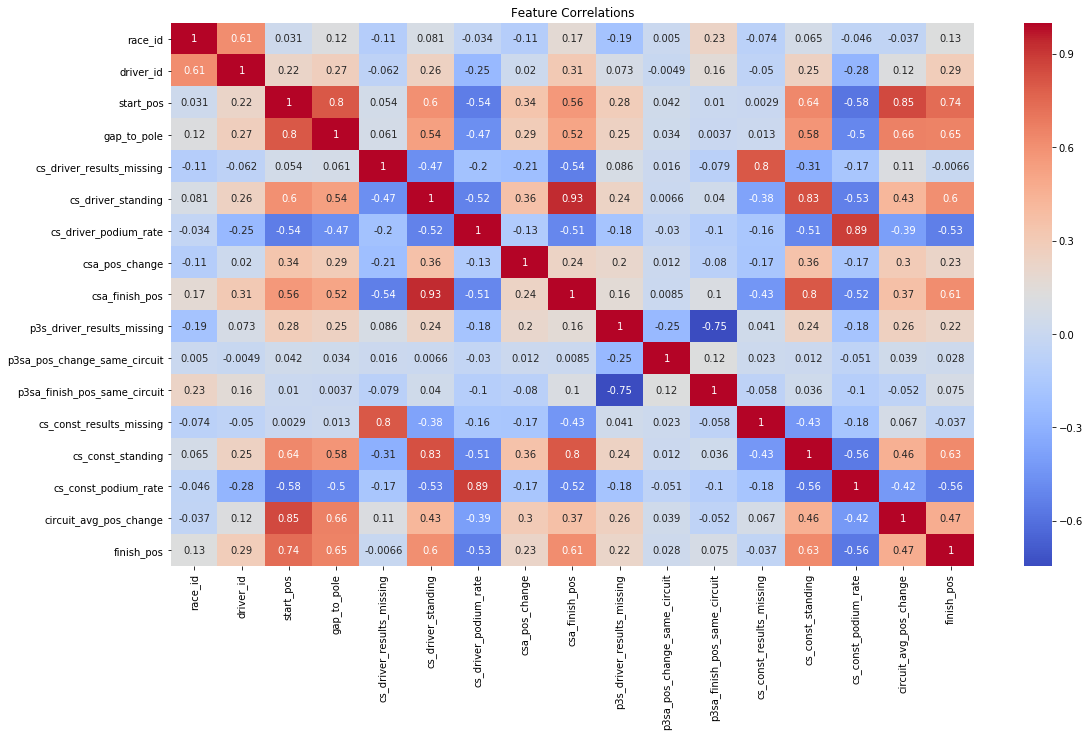

In [ ]:
import seaborn as sns

correlation = final_dataset.corr()
plt.figure(figsize=(18, 10))
plt.title("Feature Correlations")
sns.heatmap(correlation, annot=True, cmap='coolwarm')

### 7.2 Feature Importance
Feature importance provides a score for each data feature; the higher the score, the more relevant the input feature is towards the output feature (in this case, `finish_position` is the output feature). A feature importance bar graph can be drawn using an inbuilt class that comes with Tree Based Classifiers.

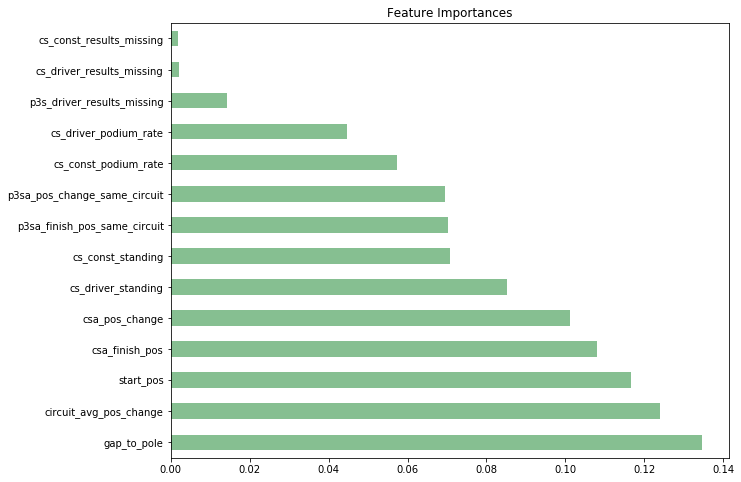

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# build a forest and compute the feature importances
model = ExtraTreesClassifier()
X = final_dataset.iloc[:, 2:16]
y = final_dataset.iloc[:, -1]
model.fit(X,y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# draw a horizontal bar graph of feature importances
feature_importances.nlargest(16).plot(kind='barh', figsize=(10, 8), color='#86bf91')
plt.title("Feature Importances")
plt.show()

As expected, `start_pos` and `gap_to_pole` were the most important input feature in determining the `finish_pos`,  while current season data appears to be more relevant in comparison to data from previous seasons.